Requirement: fsrs-optimizer >= 6.1.4

In [1]:
import numpy as np
import pandas as pd

from fsrs_optimizer import simulate, Optimizer

initial_parameters = [
    0.4783,
    1.2172,
    9.7398,
    15.8796,
    6.8942,
    0.3659,
    3.2729,
    0.0099,
    1.4107,
    0.0061,
    0.5899,
    1.68,
    0.009,
    0.4049,
    1.2676,
    0.0,
    3.0064,
    0.3535,
    0.5764,
    0.2246,
    0.2205,
]


def generate_revlog_from_simulation(initial_parameters, learn_span, seed=2023):
    flattened_revlogs = []
    deck_size = 10000
    for i, r in enumerate([0.9, 0.8, 0.7]):
        _, _, _, _, _, revlogs = simulate(
            w=initial_parameters,
            request_retention=r,
            deck_size=deck_size,
            learn_span=learn_span,
            max_cost_perday=3600,
            learning_step_count=0,
            relearning_step_count=0,
            seed=seed,
            fuzz=True,
        )

        for day in revlogs:
            card_ids = revlogs[day]["card_id"]
            ratings = revlogs[day]["rating"]
            for card_id, rating in zip(card_ids, ratings):
                flattened_revlogs.append(
                    {
                        "card_id": card_id + i * deck_size,
                        "review_rating": int(rating),
                        "day": day,
                    }
                )
    return flattened_revlogs

In [2]:
from itertools import accumulate


def preprocess_revlog(flattened_revlogs):
    df = pd.DataFrame(flattened_revlogs)
    df["review_time"] = range(1, df.shape[0] + 1)
    df.sort_values(by=["card_id", "day"], inplace=True, ignore_index=True)
    df["delta_t"] = df.groupby("card_id")["day"].diff().fillna(0).astype(int)
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["review_rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["review_rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["review_rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

In [3]:
import matplotlib.pyplot as plt

decay_list = []
trained_parameters = None


def train_and_evaluate(df):
    train_df, test_df = (
        df.iloc[: int(len(df) * 0.8)].copy(),
        df.iloc[int(len(df) * 0.8) :].copy(),
    )
    plt.close("all")
    sample_size = len(df)
    print(f"sample size: {sample_size}")
    optimizer = Optimizer(enable_short_term=False)
    optimizer.S0_dataset_group = (
        train_df[train_df["i"] == 2]
        .groupby(by=["first_rating", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    optimizer.define_model()
    optimizer.pretrain(dataset=train_df, verbose=False)
    optimizer.init_w[20] = initial_parameters[20]
    optimizer.train(gamma=0, verbose=False)
    global trained_parameters
    trained_parameters = optimizer.w
    decay_list.append(optimizer.w[20])
    # optimizer.dataset = test_df
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    deviations = []
    for param, trained_param in zip(initial_parameters, trained_parameters):
        if param == 0 and trained_param == 0:
            continue
        smape = abs(param - trained_param) / ((abs(param) + abs(trained_param)) / 2)
        deviations.append(smape)
        print(f"{param} -> {trained_param}: SMAPE={smape:.4%}")
    avg_smape = np.mean(deviations)
    print(f"Avg. SMAPE: {avg_smape:.4%}")
    return sample_size, loss_after, rmse, auc, avg_smape, optimizer.dataset


def evaluate_initial_parameters(dataset):
    optimizer = Optimizer()
    optimizer.dataset = dataset
    optimizer.w = initial_parameters
    loss_before, loss_after = optimizer.evaluate(save_to_file=False)
    print(f"loss before: {loss_before:.4f}, loss after: {loss_after:.4f}")
    metrics, figures = optimizer.calibration_graph(verbose=False)
    rmse = metrics["all"]["RMSE(bins)"]
    auc = metrics["all"]["AUC"]
    print(f"RMSE(bins): {rmse:.4f}")
    print(f"AUC: {auc:.4f}")
    return loss_after, rmse, auc

learn_span: 30
sample size: 12473


  0%|          | 0/9978 [00:00<?, ?it/s]

loss before: 0.4212, loss after: 0.3993
RMSE(bins): 0.0203
AUC: 0.6287
0.4783 -> 0.4538: SMAPE=5.2569%
1.2172 -> 1.2027: SMAPE=1.1984%
9.7398 -> 9.6086: SMAPE=1.3562%
15.8796 -> 12.8413: SMAPE=21.1574%
6.8942 -> 6.6279: SMAPE=3.9387%
0.3659 -> 0.6284: SMAPE=52.8010%
3.2729 -> 3.3647: SMAPE=2.7661%
0.0099 -> 0.0094: SMAPE=5.1813%
1.4107 -> 1.577: SMAPE=11.1323%
0.0061 -> 0.0: SMAPE=200.0000%
0.5899 -> 0.5529: SMAPE=6.4753%
1.68 -> 1.5902: SMAPE=5.4920%
0.009 -> 0.0704: SMAPE=154.6599%
0.4049 -> 0.4497: SMAPE=10.4844%
1.2676 -> 1.6118: SMAPE=23.9078%
3.0064 -> 2.0943: SMAPE=35.7637%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1883: SMAPE=15.7534%
Avg. SMAPE: 53.3346%
loss before: 0.4212, loss after: 0.3995
RMSE(bins): 0.0208
AUC: 0.6292
--------------------------------
learn_span: 60
sample size: 29757


  0%|          | 0/23805 [00:00<?, ?it/s]

loss before: 0.4346, loss after: 0.4119
RMSE(bins): 0.0148
AUC: 0.6264
0.4783 -> 0.4428: SMAPE=7.7082%
1.2172 -> 1.1612: SMAPE=4.7090%
9.7398 -> 10.1: SMAPE=3.6311%
15.8796 -> 14.99: SMAPE=5.7636%
6.8942 -> 6.7031: SMAPE=2.8109%
0.3659 -> 0.197: SMAPE=60.0107%
3.2729 -> 3.507: SMAPE=6.9057%
0.0099 -> 0.0432: SMAPE=125.4237%
1.4107 -> 1.4854: SMAPE=5.1587%
0.0061 -> 0.0002: SMAPE=187.3016%
0.5899 -> 0.5137: SMAPE=13.8094%
1.68 -> 1.5709: SMAPE=6.7120%
0.009 -> 0.0655: SMAPE=151.6779%
0.4049 -> 0.4485: SMAPE=10.2180%
1.2676 -> 1.637: SMAPE=25.4355%
3.0064 -> 2.5228: SMAPE=17.4926%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.1776: SMAPE=21.5524%
Avg. SMAPE: 58.2844%
loss before: 0.4346, loss after: 0.4119
RMSE(bins): 0.0156
AUC: 0.6265
--------------------------------
learn_span: 120
sample size: 68386


  0%|          | 0/54708 [00:00<?, ?it/s]

loss before: 0.4416, loss after: 0.4215
RMSE(bins): 0.0128
AUC: 0.6384
0.4783 -> 0.4681: SMAPE=2.1555%
1.2172 -> 1.2667: SMAPE=3.9857%
9.7398 -> 10.2888: SMAPE=5.4822%
15.8796 -> 16.4549: SMAPE=3.5584%
6.8942 -> 6.5422: SMAPE=5.2395%
0.3659 -> 0.0587: SMAPE=144.7009%
3.2729 -> 3.547: SMAPE=8.0382%
0.0099 -> 0.029: SMAPE=98.2005%
1.4107 -> 1.3997: SMAPE=0.7828%
0.0061 -> 0.0: SMAPE=200.0000%
0.5899 -> 0.5449: SMAPE=7.9309%
1.68 -> 1.62: SMAPE=3.6364%
0.009 -> 0.0716: SMAPE=155.3350%
0.4049 -> 0.4573: SMAPE=12.1550%
1.2676 -> 1.5499: SMAPE=20.0390%
0.0 -> 0.0023: SMAPE=200.0000%
3.0064 -> 3.0338: SMAPE=0.9073%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.216: SMAPE=2.0619%
Avg. SMAPE: 65.8845%
loss before: 0.4416, loss after: 0.4215
RMSE(bins): 0.0124
AUC: 0.6383
--------------------------------
learn_span: 240
sample size: 141215


  0%|          | 0/112972 [00:00<?, ?it/s]

loss before: 0.4380, loss after: 0.4205
RMSE(bins): 0.0106
AUC: 0.6302
0.4783 -> 0.5213: SMAPE=8.6034%
1.2172 -> 1.2328: SMAPE=1.2735%
9.7398 -> 10.3822: SMAPE=6.3851%
15.8796 -> 17.1335: SMAPE=7.5964%
6.8942 -> 6.6656: SMAPE=3.3717%
0.3659 -> 0.1319: SMAPE=94.0137%
3.2729 -> 3.4207: SMAPE=4.4162%
0.0099 -> 0.0152: SMAPE=42.2311%
1.4107 -> 1.3458: SMAPE=4.7089%
0.0061 -> 0.0: SMAPE=200.0000%
0.5899 -> 0.6218: SMAPE=5.2653%
1.68 -> 1.6117: SMAPE=4.1498%
0.009 -> 0.081: SMAPE=160.0000%
0.4049 -> 0.4404: SMAPE=8.3994%
1.2676 -> 1.7218: SMAPE=30.3874%
0.0 -> 0.0098: SMAPE=200.0000%
3.0064 -> 2.9901: SMAPE=0.5437%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.2152: SMAPE=2.4329%
Avg. SMAPE: 61.5783%
loss before: 0.4380, loss after: 0.4204
RMSE(bins): 0.0103
AUC: 0.6309
--------------------------------
learn_span: 480
sample size: 251745


  0%|          | 0/201396 [00:00<?, ?it/s]

loss before: 0.4195, loss after: 0.4045
RMSE(bins): 0.0084
AUC: 0.6246
0.4783 -> 0.4918: SMAPE=2.7832%
1.2172 -> 1.2699: SMAPE=4.2379%
9.7398 -> 10.5549: SMAPE=8.0326%
15.8796 -> 17.8362: SMAPE=11.6064%
6.8942 -> 6.4312: SMAPE=6.9491%
0.3659 -> 0.1998: SMAPE=58.7237%
3.2729 -> 3.1844: SMAPE=2.7411%
0.0099 -> 0.0116: SMAPE=15.8140%
1.4107 -> 1.1693: SMAPE=18.7132%
0.0061 -> 0.0: SMAPE=200.0000%
0.5899 -> 0.6871: SMAPE=15.2232%
1.68 -> 1.692: SMAPE=0.7117%
0.009 -> 0.0296: SMAPE=106.7358%
0.4049 -> 0.4026: SMAPE=0.5697%
1.2676 -> 1.5527: SMAPE=20.2177%
0.0 -> 0.0031: SMAPE=200.0000%
3.0064 -> 3.073: SMAPE=2.1910%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.2378: SMAPE=7.5496%
Avg. SMAPE: 56.7698%
loss before: 0.4195, loss after: 0.4045
RMSE(bins): 0.0086
AUC: 0.6247
--------------------------------
learn_span: 960
sample size: 381269


  0%|          | 0/305015 [00:00<?, ?it/s]

loss before: 0.4131, loss after: 0.4006
RMSE(bins): 0.0083
AUC: 0.6208
0.4783 -> 0.4994: SMAPE=4.3163%
1.2172 -> 1.2702: SMAPE=4.2615%
9.7398 -> 10.3522: SMAPE=6.0960%
15.8796 -> 17.6181: SMAPE=10.3798%
6.8942 -> 6.3086: SMAPE=8.8708%
0.3659 -> 0.1894: SMAPE=63.5692%
3.2729 -> 3.1511: SMAPE=3.7920%
0.0099 -> 0.0156: SMAPE=44.7059%
1.4107 -> 1.026: SMAPE=31.5755%
0.0061 -> 0.0012: SMAPE=134.2466%
0.5899 -> 0.7655: SMAPE=25.9112%
1.68 -> 1.8252: SMAPE=8.2848%
0.009 -> 0.0854: SMAPE=161.8644%
0.4049 -> 0.4027: SMAPE=0.5448%
1.2676 -> 1.7183: SMAPE=30.1886%
0.0 -> 0.0127: SMAPE=200.0000%
3.0064 -> 3.0817: SMAPE=2.4737%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.2205: SMAPE=0.0000%
Avg. SMAPE: 59.5451%
loss before: 0.4131, loss after: 0.4005
RMSE(bins): 0.0084
AUC: 0.6210
--------------------------------
learn_span: 1920
sample size: 532209


  0%|          | 0/425767 [00:00<?, ?it/s]

loss before: 0.4139, loss after: 0.4027
RMSE(bins): 0.0075
AUC: 0.6221
0.4783 -> 0.4835: SMAPE=1.0813%
1.2172 -> 1.1941: SMAPE=1.9160%
9.7398 -> 10.4711: SMAPE=7.2367%
15.8796 -> 18.8124: SMAPE=16.9076%
6.8942 -> 6.2366: SMAPE=10.0161%
0.3659 -> 0.17: SMAPE=73.1107%
3.2729 -> 3.1975: SMAPE=2.3306%
0.0099 -> 0.0147: SMAPE=39.0244%
1.4107 -> 0.9192: SMAPE=42.1907%
0.0061 -> 0.0002: SMAPE=187.3016%
0.5899 -> 0.8686: SMAPE=38.2173%
1.68 -> 1.8611: SMAPE=10.2285%
0.009 -> 0.0888: SMAPE=163.1902%
0.4049 -> 0.4071: SMAPE=0.5419%
1.2676 -> 1.6454: SMAPE=25.9389%
0.0 -> 0.0026: SMAPE=200.0000%
3.0064 -> 3.0499: SMAPE=1.4365%
0.3535 -> 0.0: SMAPE=200.0000%
0.5764 -> 0.0: SMAPE=200.0000%
0.2246 -> 0.0658: SMAPE=109.3664%
0.2205 -> 0.2341: SMAPE=5.9833%
Avg. SMAPE: 63.6199%
loss before: 0.4139, loss after: 0.4027
RMSE(bins): 0.0075
AUC: 0.6225
--------------------------------


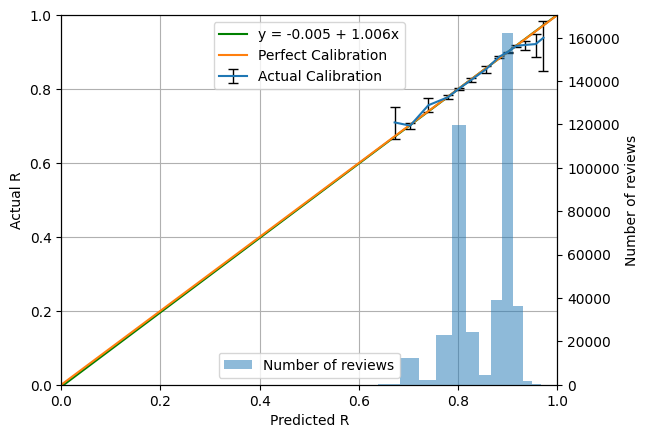

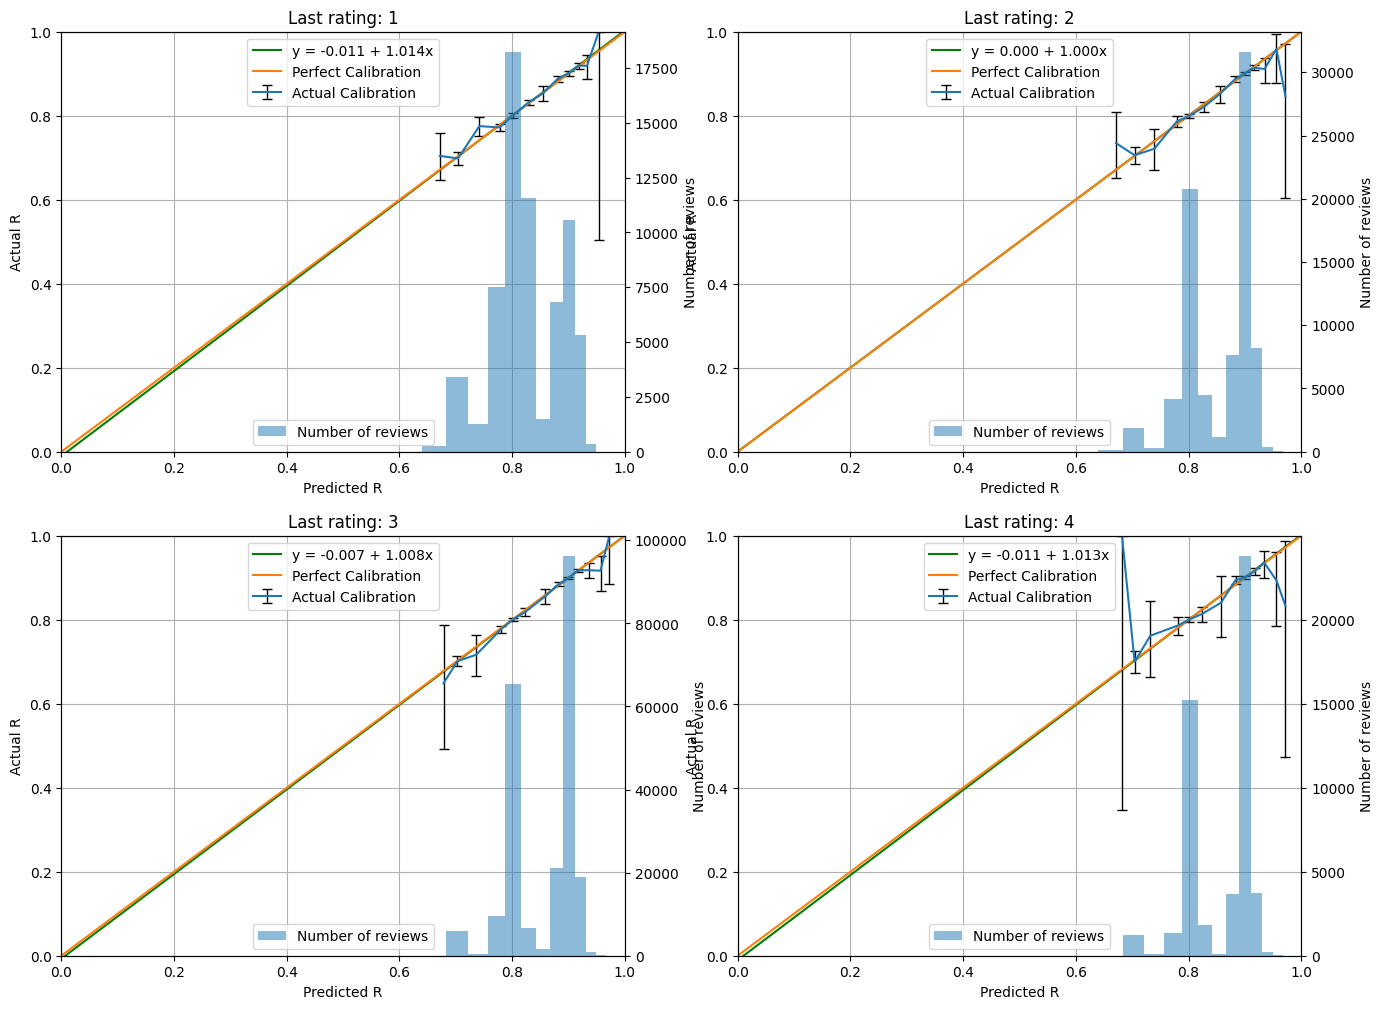

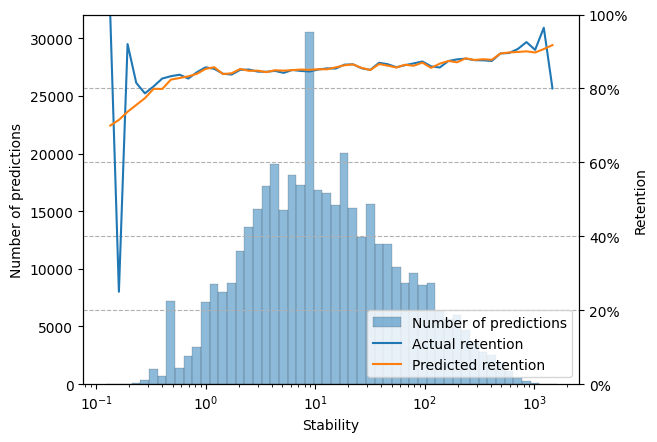

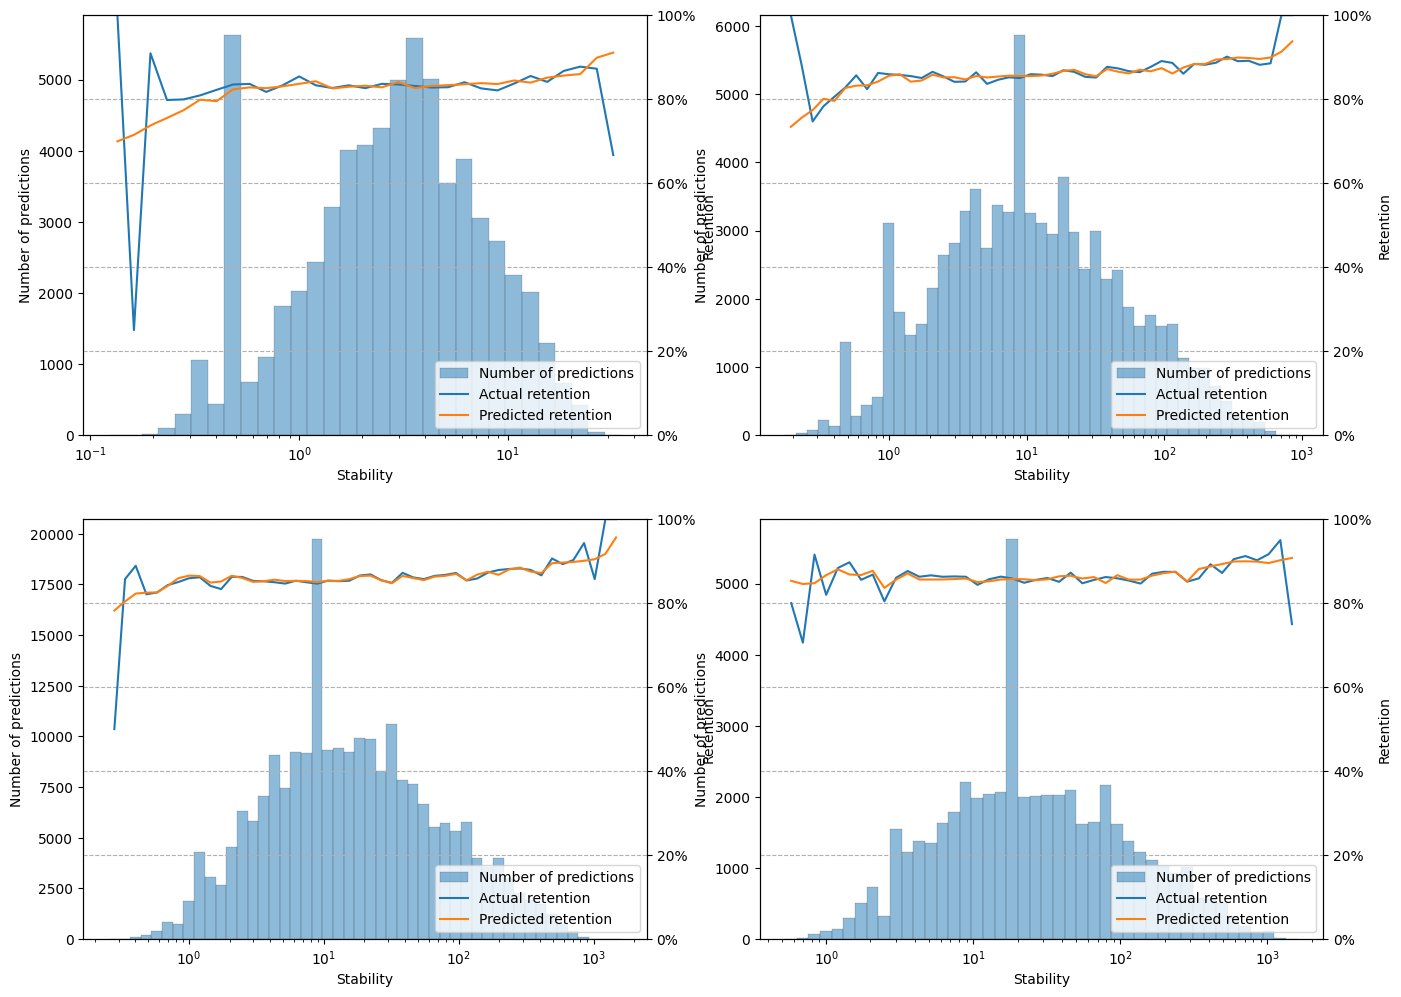

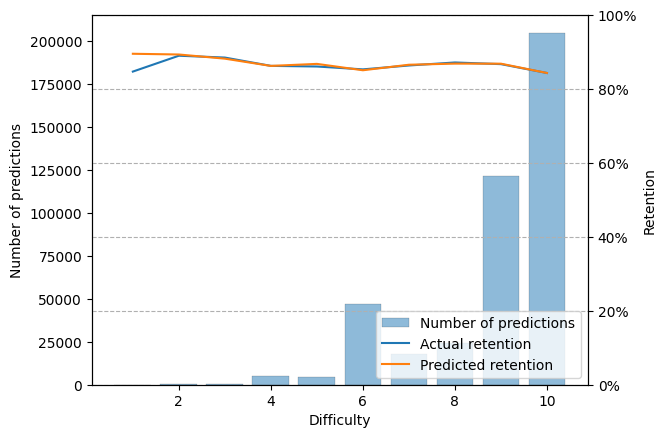

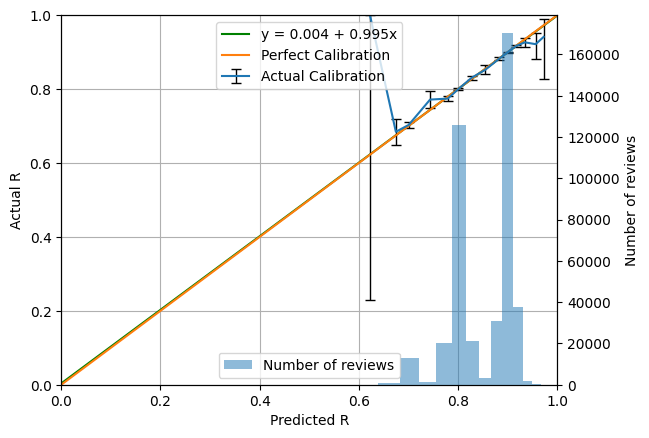

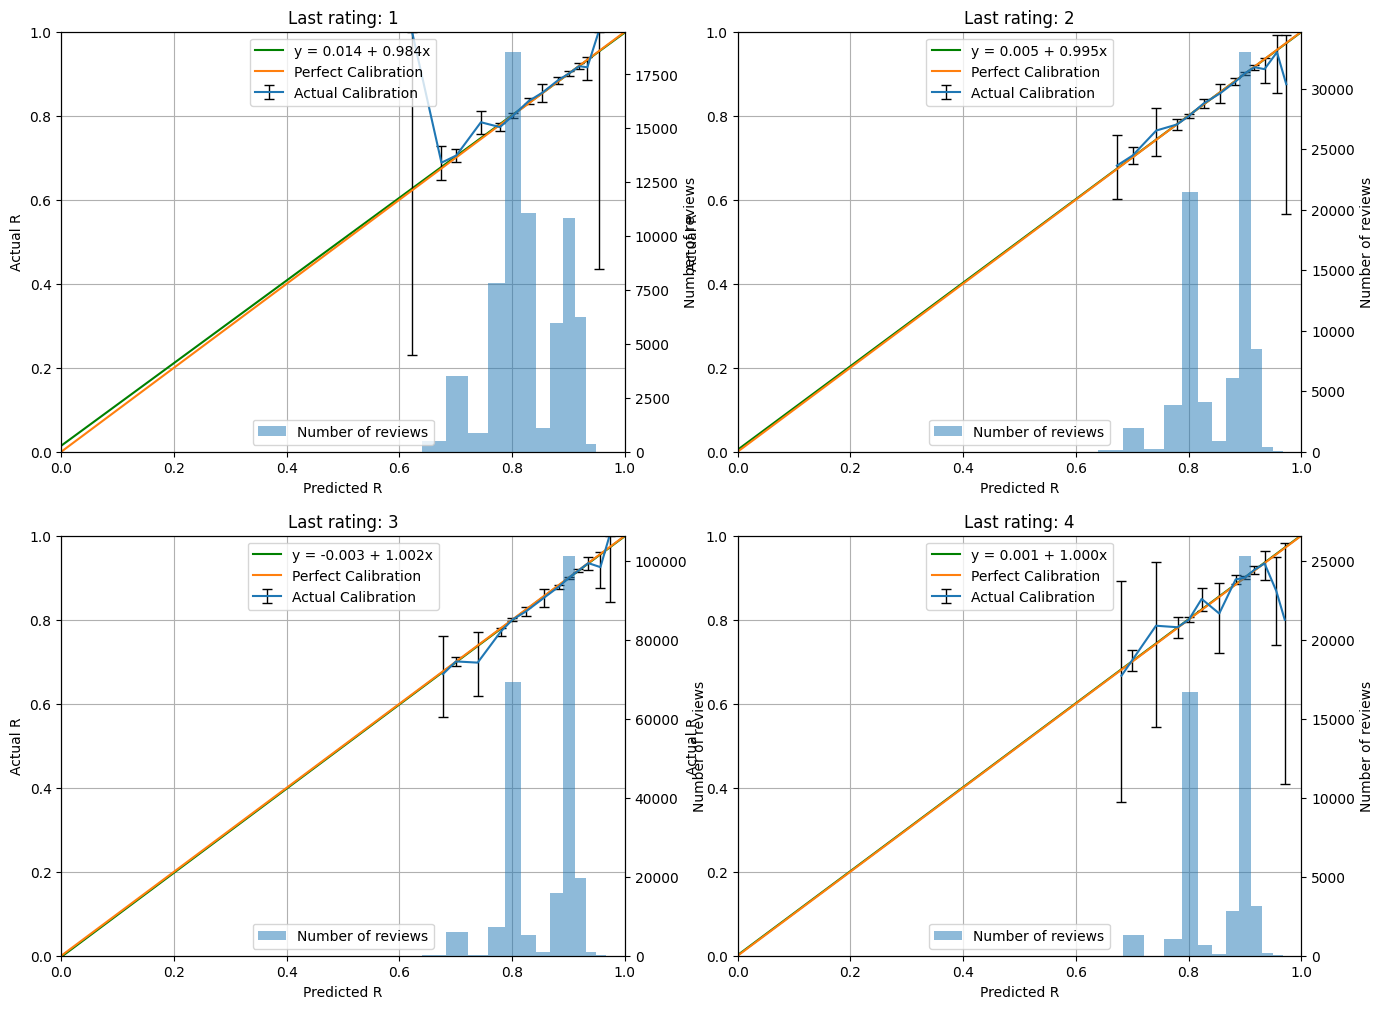

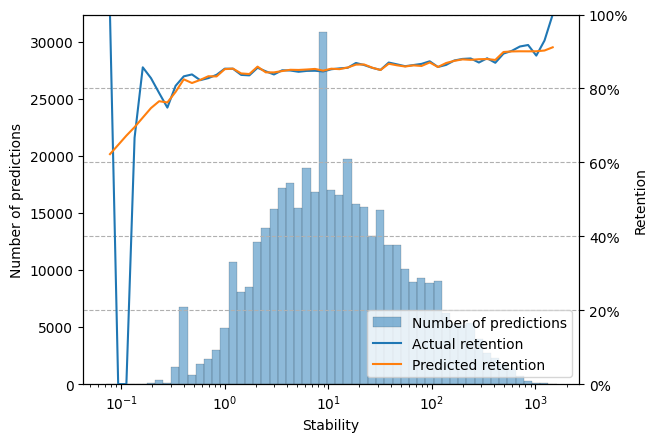

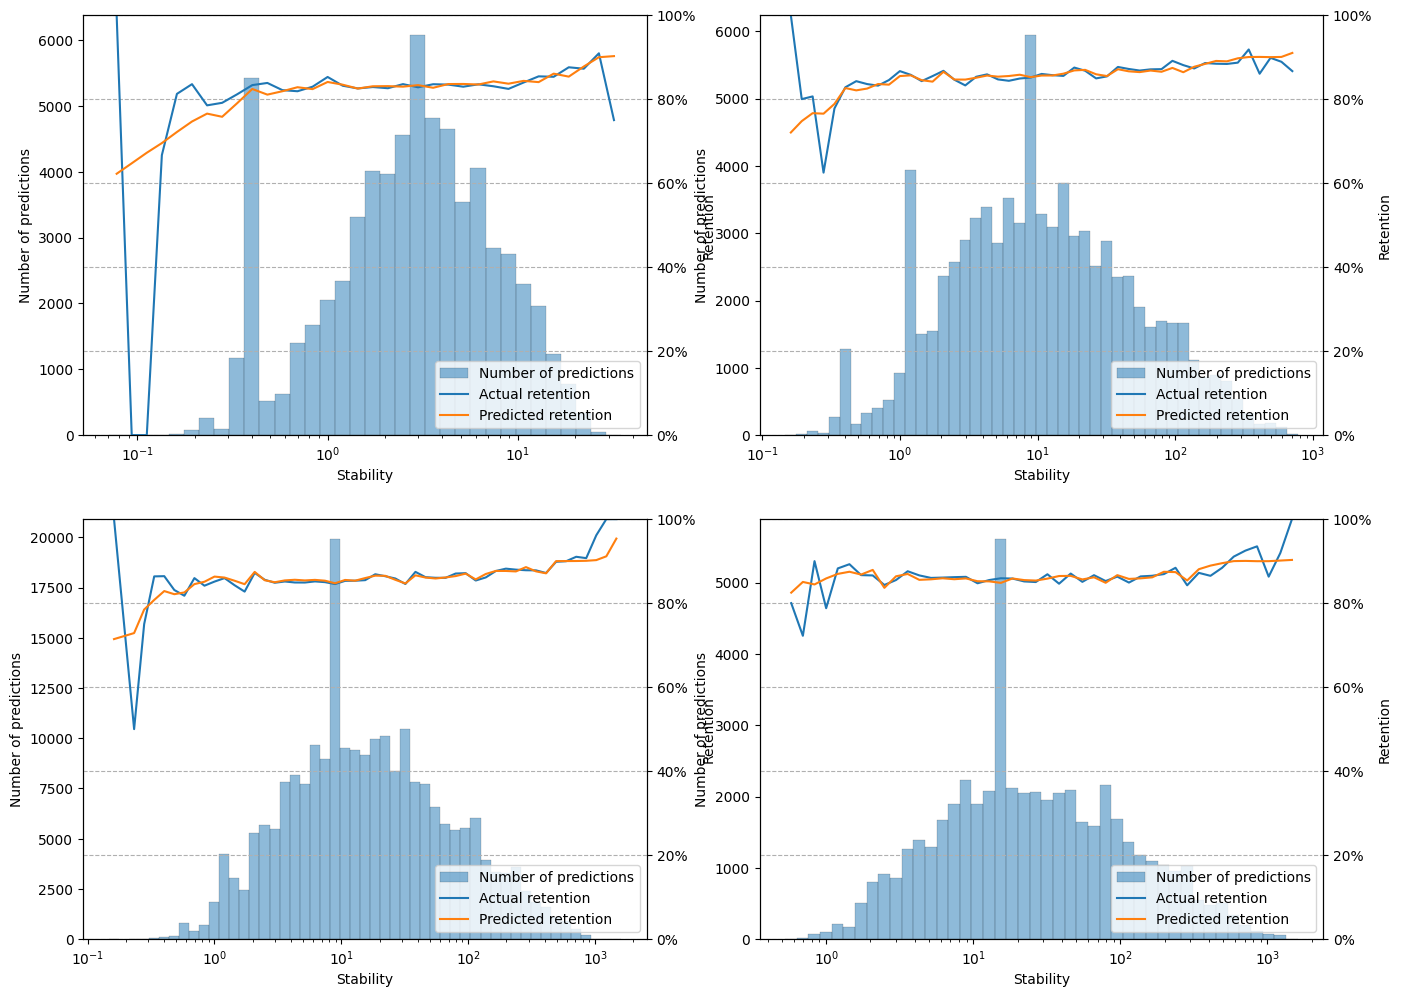

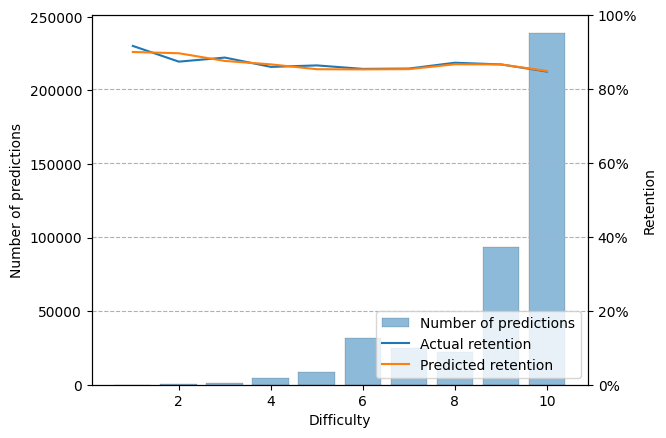

In [4]:
learn_span_list = [30, 60, 120, 240, 480, 960, 1920]
sample_size_list = []
logloss_list = []
rmse_list = []
auc_list = []
avg_smape_list = []
ideal_logloss_list = []
ideal_rmse_list = []
ideal_auc_list = []

for learn_span in learn_span_list:
    print(f"learn_span: {learn_span}")
    revlogs = generate_revlog_from_simulation(
        initial_parameters, learn_span=learn_span, seed=2023
    )
    df = preprocess_revlog(revlogs)
    sample_size, logloss, rmse, auc, avg_smape, dataset = train_and_evaluate(df)
    sample_size_list.append(sample_size)
    logloss_list.append(logloss)
    rmse_list.append(rmse)
    auc_list.append(auc)
    avg_smape_list.append(avg_smape)

    ideal_logloss, ideal_rmse, ideal_auc = evaluate_initial_parameters(dataset)
    ideal_logloss_list.append(ideal_logloss)
    ideal_rmse_list.append(ideal_rmse)
    ideal_auc_list.append(ideal_auc)

    print("--------------------------------")

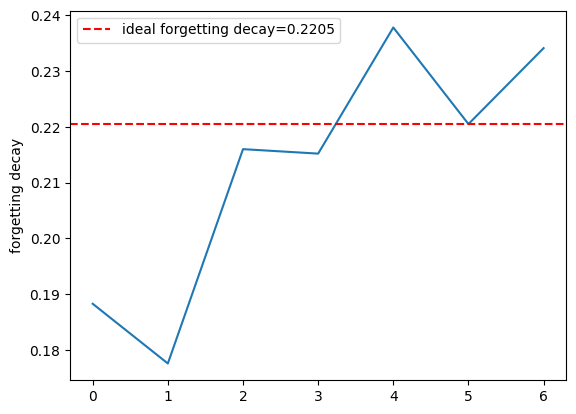

In [12]:
plt.plot(decay_list)
plt.axhline(y=initial_parameters[20], color='r', linestyle='--', label=f'ideal forgetting decay={initial_parameters[20]:.4f}')
plt.ylabel("forgetting decay")
plt.legend()
plt.show()

In [6]:
np.set_printoptions(precision=6, suppress=True)
print(
    f"logloss (trained - ideal): {np.array(logloss_list) - np.array(ideal_logloss_list)}"
)
print(
    f"RMSE(bins) (trained - ideal): {np.array(rmse_list) - np.array(ideal_rmse_list)}"
)
print(f"AUC (trained - ideal): {np.array(auc_list) - np.array(ideal_auc_list)}")

logloss (trained - ideal): [-0.000151 -0.000032  0.000009  0.000091  0.000022  0.000038  0.000044]
RMSE(bins) (trained - ideal): [-0.000498 -0.000789  0.000389  0.0003   -0.000217 -0.000081  0.000007]
AUC (trained - ideal): [-0.00056  -0.000086  0.000131 -0.000752 -0.000129 -0.000249 -0.00034 ]


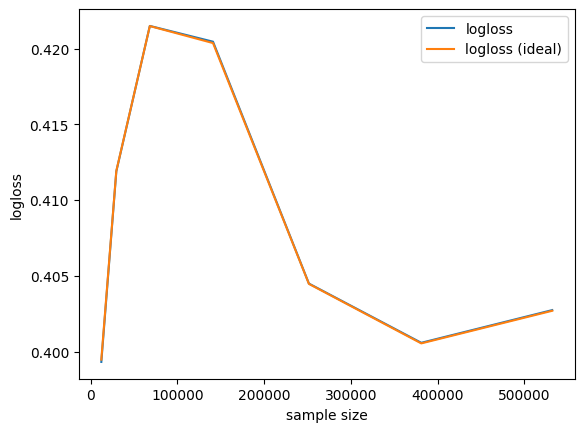

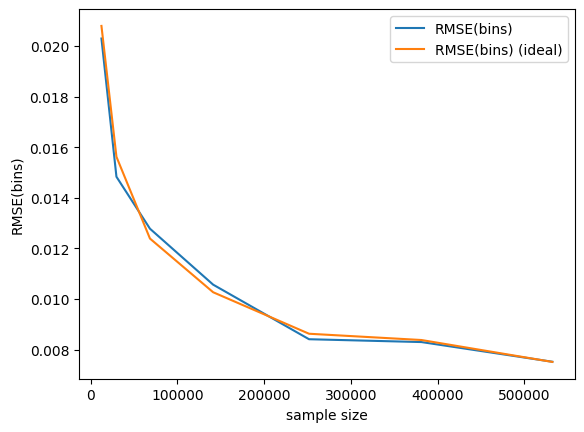

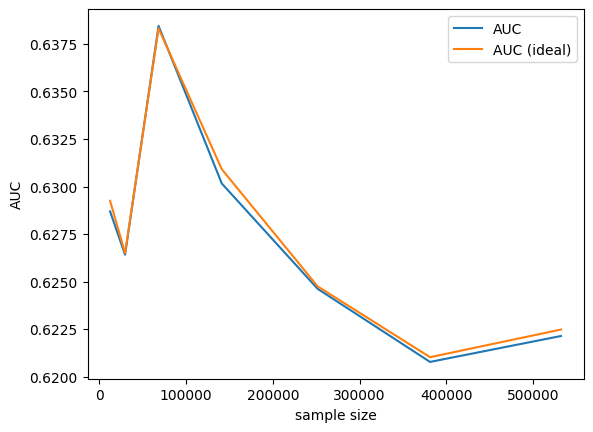

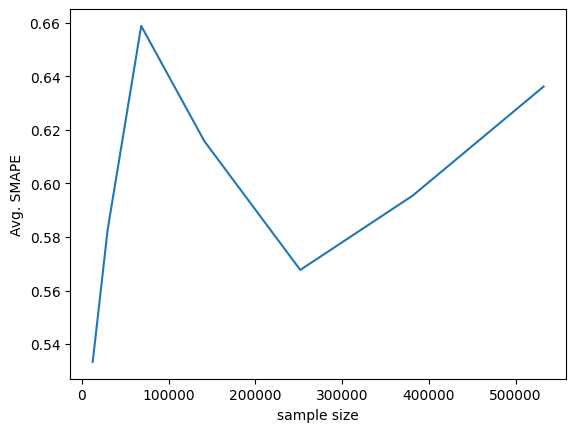

In [7]:
plt.plot(sample_size_list, logloss_list, label="logloss")
plt.plot(sample_size_list, ideal_logloss_list, label="logloss (ideal)")
plt.ylabel("logloss")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, rmse_list, label="RMSE(bins)")
plt.plot(sample_size_list, ideal_rmse_list, label="RMSE(bins) (ideal)")
plt.ylabel("RMSE(bins)")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, auc_list, label="AUC")
plt.plot(sample_size_list, ideal_auc_list, label="AUC (ideal)")
plt.ylabel("AUC")
plt.xlabel("sample size")
plt.legend()
plt.show()
plt.plot(sample_size_list, avg_smape_list)
plt.ylabel("Avg. SMAPE")
plt.xlabel("sample size")
plt.show()

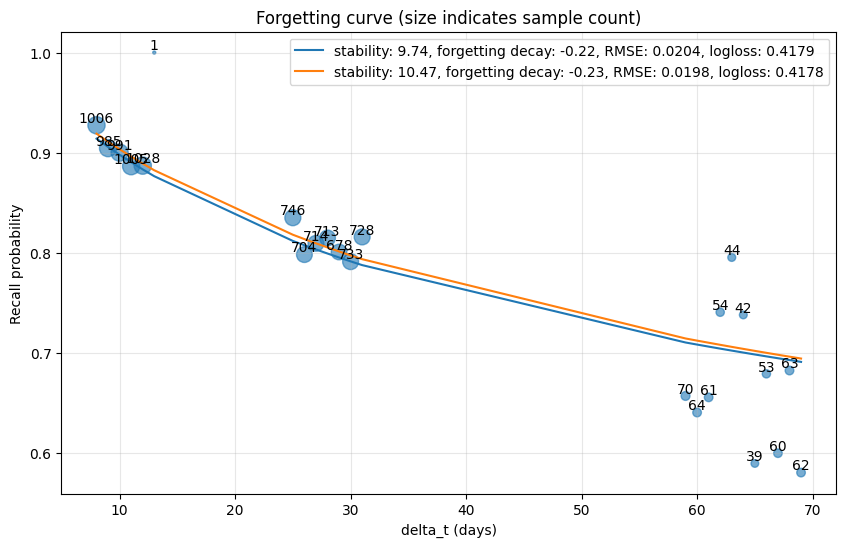

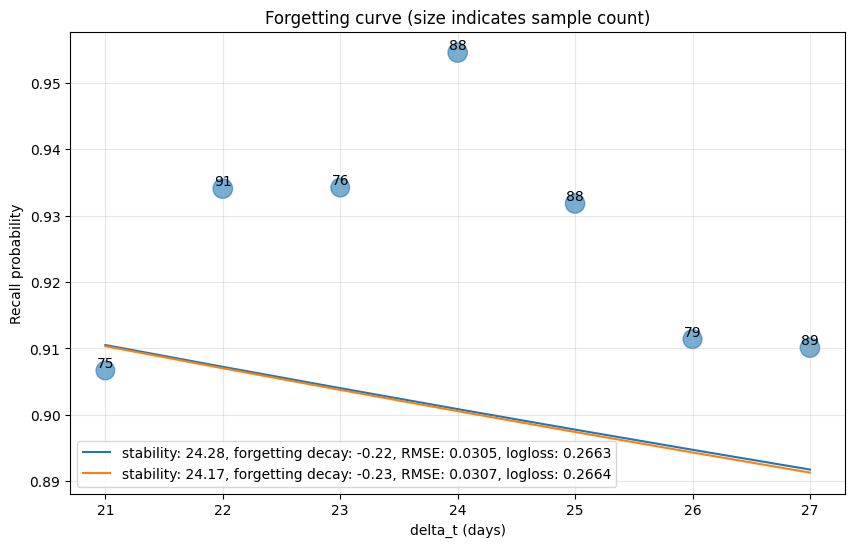

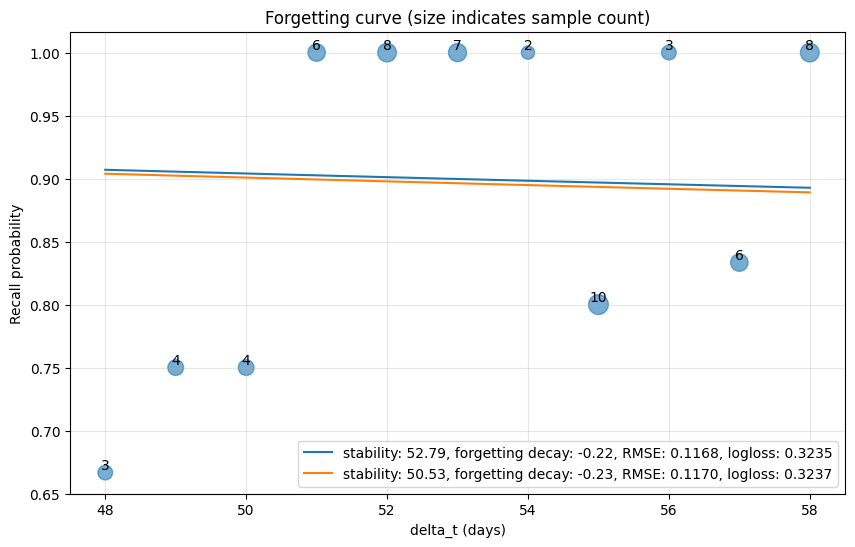

In [8]:
from fsrs_optimizer import power_forgetting_curve
from sklearn.metrics import root_mean_squared_error, log_loss

initial = Optimizer()
initial.dataset = dataset.copy()
initial.w = initial_parameters
loss_before, loss_after = initial.evaluate(save_to_file=False)
trained = Optimizer()
trained.dataset = dataset.copy()
trained.w = trained_parameters
loss_before, loss_after = trained.evaluate(save_to_file=False)
for r_history in ["3", "3,3", "3,3,3"]:
    t_history = df[df["r_history"] == r_history]["t_history"].value_counts().index[0]
    stabilities = []
    for df in [initial.dataset, trained.dataset]:
        tmp = df[(df["r_history"] == r_history) & (df["t_history"] == t_history)]
        points = tmp.groupby("delta_t")["y"].agg(["mean", "count"])
        stabilities.append(tmp["stability"].unique()[0])
    y_true = points["mean"]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        points.index,
        y_true,
        s=np.sqrt(points["count"] / sum(points["count"])) * 500,
        alpha=0.6,
    )
    for x, y in zip(points.index, y_true):
        plt.text(x, y, points["count"][x], ha="center", va="bottom")

    for s, d in zip(stabilities, [initial_parameters[20], trained_parameters[20]]):
        y_pred = power_forgetting_curve(points.index, s, -d)
        rmse = root_mean_squared_error(y_true, y_pred, sample_weight=points["count"])
        logloss = log_loss(
            tmp["y"],
            power_forgetting_curve(tmp["delta_t"], s, -d),
        )
        plt.plot(
            points.index,
            y_pred,
            label=f"stability: {s:.2f}, forgetting decay: {-d:.2f}, RMSE: {rmse:.4f}, logloss: {logloss:.4f}",
        )
    plt.xlabel("delta_t (days)")
    plt.ylabel("Recall probability")
    plt.title("Forgetting curve (size indicates sample count)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

In [9]:
from fsrs_optimizer import FSRS
import torch


def calculate_retention(parameters, r_history, t_history, next_interval):
    """Calculate retention for given review history and parameters"""
    fsrs = FSRS(parameters)
    tensor = torch.tensor([t_history, r_history]).transpose(0, 1).unsqueeze(1)
    _, state = fsrs.forward(tensor)
    stability = state[0][0].item()
    retention = power_forgetting_curve(next_interval, stability, -parameters[20])
    print(next_interval, retention)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 30)
calculate_retention(initial_parameters, [3, 3], [0, 30], 145)

# Trained parameters
calculate_retention(trained_parameters, [3], [0], 30)
calculate_retention(trained_parameters, [3, 3], [0, 30], 145)


# Initial parameters
calculate_retention(initial_parameters, [3], [0], 15)
calculate_retention(initial_parameters, [3, 3], [0, 15], 40)

# Trained parameters
calculate_retention(trained_parameters, [3], [0], 15)
calculate_retention(trained_parameters, [3, 3], [0, 15], 40)

30 0.7915504103679721
145 0.7616836320342888
30 0.7975267545263369
145 0.7585961718488436
15 0.8637188083443708
40 0.866692434992662
15 0.8698376552678249
40 0.8657224361737137


In [10]:
from fsrs_optimizer import next_interval

s = 100
for dr in [0.9, 0.8, 0.7, 0.5]:
    print(f"stability: {s}, desired retention: {dr}")
    ivl = next_interval(s, dr, decay=-initial_parameters[20])
    true_retention = power_forgetting_curve(ivl, s, -initial_parameters[20])
    print(f"initial: {ivl}, true retention: {true_retention:.2f}")
    ivl = next_interval(s, dr, decay=-trained_parameters[20])
    true_retention = power_forgetting_curve(ivl, s, -initial_parameters[20])
    print(f"trained: {ivl}, true retention: {true_retention:.2f}")
    print()

stability: 100, desired retention: 0.9
initial: 100, true retention: 0.90
trained: 100, true retention: 0.90

stability: 100, desired retention: 0.8
initial: 286, true retention: 0.80
trained: 280, true retention: 0.80

stability: 100, desired retention: 0.7
initial: 660, true retention: 0.70
trained: 631, true retention: 0.71

stability: 100, desired retention: 0.5
initial: 3622, true retention: 0.50
trained: 3222, true retention: 0.51

